In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#set a random seed for replication
seed = 183830
np.random.seed(seed)
#read in training data
df = pd.read_csv('final_dataset.csv')

In [20]:
print(df['GlobalClass'].unique())

['Benign' 'Light Attack' 'Light Benign' 'Heavy Attack' 'Heavy Benign']


In [21]:
df['GlobalClass'].value_counts()


Benign          83183
Heavy Benign    68057
Light Benign    24403
Heavy Attack     5764
Light Attack     2462
Name: GlobalClass, dtype: int64

In [22]:
df['GlobalClass'] = df['GlobalClass'].map({'Benign':0,'Light Benign':0,'Heavy Benign':0, 'Light Attack':1, 'Heavy Attack':2})


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183869 entries, 0 to 183868
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   A_frequency       183869 non-null  float64
 1   PTR_frequency     183869 non-null  float64
 2   TXT_frequency     183869 non-null  float64
 3   rr_count          183869 non-null  float64
 4   rr_name_entropy   183869 non-null  float64
 5   rr_name_length    183869 non-null  float64
 6   distinct_ns       183869 non-null  float64
 7   ttl_mean          183869 non-null  float64
 8   ttl_variance      183869 non-null  float64
 9   FQDN_count        183869 non-null  int64  
 10  subdomain_length  183869 non-null  int64  
 11  upper             183869 non-null  int64  
 12  lower             183869 non-null  int64  
 13  numeric           183869 non-null  int64  
 14  entropy           183869 non-null  float64
 15  special           183869 non-null  int64  
 16  labels            18

In [24]:
feature_names = list(df.columns)
print(feature_names)
feature_names.remove('GlobalClass')
target_names = ['0', '1', '2']

['A_frequency', 'PTR_frequency', 'TXT_frequency', 'rr_count', 'rr_name_entropy', 'rr_name_length', 'distinct_ns', 'ttl_mean', 'ttl_variance', 'FQDN_count', 'subdomain_length', 'upper', 'lower', 'numeric', 'entropy', 'special', 'labels', 'labels_max', 'labels_average', 'longest_word', 'sld', 'len', 'subdomain', 'GlobalClass']


In [25]:
from sklearn.model_selection import train_test_split

#create feature and targets
features = df.drop('GlobalClass', axis=1)
target = df['GlobalClass']
#split data into 80% training and 20% test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=seed)

In [26]:
#size for the sets
print('size of X_train:', X_train.shape)
print('size of X_test:', X_test.shape)
print('size of y_train:', y_train.shape)
print('size of y_test:', y_test.shape)

size of X_train: (147095, 23)
size of X_test: (36774, 23)
size of y_train: (147095,)
size of y_test: (36774,)


In [27]:
from sklearn.ensemble import HistGradientBoostingClassifier
hgb_classifier = HistGradientBoostingClassifier(class_weight='balanced')
hgb_classifier.fit(X_train,y_train)
y_pred_hgb = hgb_classifier.predict(X_test)
hgb_classifier.score(X_train, y_train)

0.9621945001529624

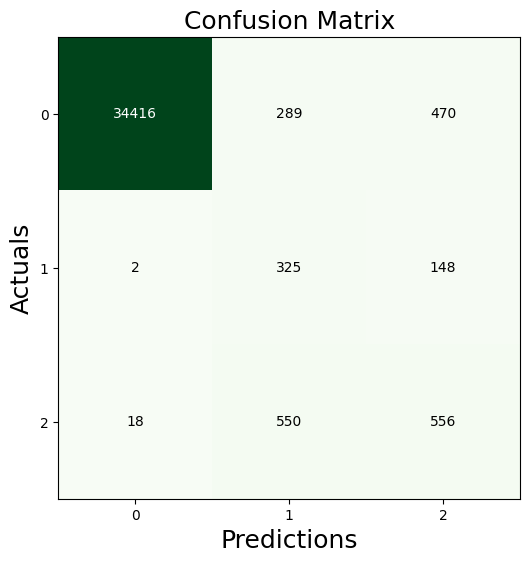

In [28]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
cm_hgb = confusion_matrix(y_test, y_pred_hgb)

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm_hgb, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
accuracy_score(y_test, y_pred_hgb)

0.9598357535215097

In [30]:
pred_prob = hgb_classifier.predict_proba(X_test)
roc_auc_score(y_test, pred_prob, multi_class='ovo')

0.8650570125318607

In [31]:
acc_hgb = cross_val_score(estimator = hgb_classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy of hgb: {:.2f} %".format(acc_hgb.mean()*100))
print("SD of hgb: {:.2f} %".format(acc_hgb.std()*100))
print(classification_report(y_test, y_pred_hgb))

Accuracy of hgb: 95.99 %
SD of hgb: 0.12 %
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     35175
           1       0.28      0.68      0.40       475
           2       0.47      0.49      0.48      1124

    accuracy                           0.96     36774
   macro avg       0.58      0.72      0.62     36774
weighted avg       0.97      0.96      0.97     36774



In [32]:
from sklearn.model_selection import GridSearchCV
parameters_hgb = [{'max_iter': [1000,1200,1500],
                'learning_rate': [0.1],
                'max_depth' : [25, 50, 75],
                'l2_regularization': [1.5],
                'scoring': ['f1_micro']}]
grid_search_hgb = GridSearchCV(estimator = hgb_classifier,
                           param_grid = parameters_hgb,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search_hgb.fit(X_train, y_train)
best_accuracy_hgb = grid_search_hgb.best_score_
best_paramaeter_hgb = grid_search_hgb.best_params_  
print("Best Accuracy of HGB: {:.2f} %".format(best_accuracy_hgb.mean()*100))
print("Best Parameter of HGB:", best_paramaeter_hgb)

Best Accuracy of HGB: 95.86 %
Best Parameter of HGB: {'l2_regularization': 1.5, 'learning_rate': 0.1, 'max_depth': 25, 'max_iter': 1500, 'scoring': 'f1_micro'}


In [33]:
from trustee import ClassificationTrustee
from sklearn import tree

trustee = ClassificationTrustee(expert=hgb_classifier)
trustee.fit(X_train, y_train, num_iter=50, num_stability_iter=10, samples_size=0.3, verbose=True)

# Get the best explanation from Trustee
dt, pruned_dt, agreement, reward = trustee.explain()
print(f"Model explanation training (agreement, fidelity): ({agreement}, {reward})")
print(f"Model Explanation size: {dt.tree_.node_count}")
print(f"Top-k Prunned Model explanation size: {pruned_dt.tree_.node_count}")

# Use explanations to make predictions
dt_y_pred = dt.predict(X_test)
pruned_dt_y_pred = pruned_dt.predict(X_test)

# Evaluate accuracy and fidelity of explanations
print("Model explanation global fidelity report:")
print(classification_report(y_pred_hgb, dt_y_pred))
print("Top-k Model explanation global fidelity report:")
print(classification_report(y_pred_hgb, pruned_dt_y_pred))

print("Model explanation score report:")
print(classification_report(y_test, dt_y_pred))
print("Top-k Model explanation score report:")
print(classification_report(y_test, pruned_dt_y_pred))

Initializing training dataset using HistGradientBoostingClassifier(class_weight='balanced') as expert model
Expert model score: 0.6582843301089244
Initializing Trustee outer-loop with 10 iterations
########## Outer-loop Iteration 0/10 ##########
Initializing Trustee inner-loop with 10 iterations
########## Inner-loop Iteration 0/50 ##########
Sampling 30889 points from training dataset with (102966, 102966) entries
Student model 0-0 trained with depth 19 and 261 leaves:
Student model score: 0.9451479169124409
Student model 0-0 fidelity: 0.9451479169124409
########## Inner-loop Iteration 1/50 ##########
Sampling 30889 points from training dataset with (112233, 112233) entries
Student model 0-1 trained with depth 19 and 263 leaves:
Student model score: 0.9461976741788019
Student model 0-1 fidelity: 0.9461976741788019
########## Inner-loop Iteration 2/50 ##########
Sampling 30889 points from training dataset with (121500, 121500) entries
Student model 0-2 trained with depth 19 and 271 lea

/home/emily_hu/venv/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/emily_hu/venv/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/emily_hu/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/emily_hu/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resul

In [34]:
# Output decision tree to pdf
dot_data = tree.export_graphviz(
    dt,
    class_names=target_names,
    feature_names=feature_names,
    filled=True,
    rounded=True,
    special_characters=True,
)


In [35]:
import pickle

with open('dot_data.pkl', 'wb') as f:  # open a text file
    pickle.dump(dot_data, f)
with open('pruned_dt.pkl', 'wb') as f:  # open a text file
    pickle.dump(pruned_dt, f)
with open('dt.pkl', 'wb') as f:
    pickle.dump(dt, f)

In [36]:
print(target_names)
print(feature_names)

['0', '1', '2']
['A_frequency', 'PTR_frequency', 'TXT_frequency', 'rr_count', 'rr_name_entropy', 'rr_name_length', 'distinct_ns', 'ttl_mean', 'ttl_variance', 'FQDN_count', 'subdomain_length', 'upper', 'lower', 'numeric', 'entropy', 'special', 'labels', 'labels_max', 'labels_average', 'longest_word', 'sld', 'len', 'subdomain']
